# SIR model - Split Approach

Solving the SIR model with constant transmission rate $\beta$ and recovery rate $\delta$.

$$
\begin{cases}
\frac{dS}{dt} &= -\frac{\beta}{N} I S, \\
\frac{dI}{dt} &= \frac{\beta}{N} I S - \delta I, \\
\frac{dR}{dt} &= \delta I,
\end{cases}
$$

where $t \in [0, 90]$ and with the initial conditions $S(0) = N - 1$, $I(0) = 1$, and $R(0) = 0$.

## Environment Setup

Load .env file, which specifies which backend DeepXDE should use

In [20]:
from dotenv import load_dotenv

load_dotenv()

True

In [21]:
import torch
import deepxde as dde
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d

Enable latex in matplotlib and set seaborn theme.

In [22]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

sns.set_theme(style="darkgrid")

Set random seed for reproducibility

In [23]:
seed = 2322

np.random.seed(seed)
torch.manual_seed(seed)
dde.config.set_random_seed(seed)

## Synthetic data generation

Building a SIR model to generate a discrete synthetic dataset in a closed time interval.

This dataset will be used as a starting point for creating both the true solution used during the l2 regularization term and observed data used during the training of the network.

### System configuration

The following parameters are used (using Italy as reference):

In [24]:
N = 56e6  # total population
delta = 1 / 5  # recovery rate (1 / mean infectious period)
r0 = 3.0  # basic reproduction number
beta = delta * r0  # transmission rate

The following time interval is used:

In [25]:
T0, TF = 0, 90  # (days)

### System definition

Define the SIR model and the initial conditions.

In [26]:
def SIR(x, t, delta, beta, N):
  S, I, R = x
  _lambda = beta * I / N
  dSdt = -_lambda * S
  dIdt = _lambda * S - delta * I
  dRdt = delta * I
  return [dSdt, dIdt, dRdt]


S0 = N - 1
I0 = 1
R0 = 0

Define a function to generate a discrete solution for the SIR model based on a time interval.

In [27]:
def solve_sir(t):
  x = odeint(SIR, [S0, I0, R0], t, args=(delta, beta, N))
  S = x[:, 0]
  I = x[:, 1]
  R = x[:, 2]
  return S, I, R

### Data generation

Generate a synthetic dataset and a synthetic observation of $I(t)$ by adding some noise to the true solution.

In [28]:
t_train = np.linspace(T0, TF, TF - T0 + 1)
S_data, I_data, R_data = solve_sir(t_train)

I_train = np.random.poisson(I_data)

Plot the synthetic dataset and the observed $I(t)$.

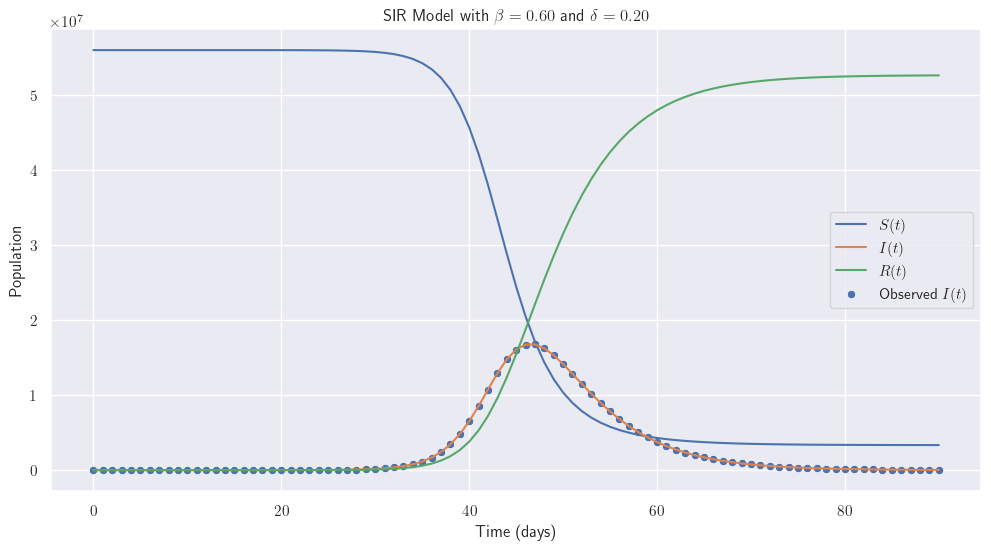

In [29]:
plt.subplots(figsize=(12, 6))

sns.lineplot(x=t_train, y=S_data, label=r"$S(t)$")
sns.lineplot(x=t_train, y=I_data, label=r"$I(t)$")
sns.lineplot(x=t_train, y=R_data, label=r"$R(t)$")
sns.scatterplot(x=t_train, y=I_train, label=r"Observed $I(t)$")

plt.title(
  r"SIR Model with $\beta = {:.2f}$ and $\delta = {:.2f}$".format(beta, delta)
)
plt.xlabel(r"Time (days)")
plt.ylabel(r"Population")

plt.savefig("data/split/synthetic_data.png")

Generate a test dataset with a different time interval.

In [30]:
t_test = np.linspace(T0, TF, 100)
_, I_test, _ = solve_sir(t_test)

I_test = np.random.poisson(I_test)

## Data Scaling

Scale both dataset and observation by a constant $C$ and into a time interval $[0, 1]$.

This is necessary to avoid numerical instability during the training of the network.

Define the scaling and unscaling functions.

In [31]:
C = 1e5


def scale_time(t):
  return t / TF


def unscale_time(t):
  return t * TF


def scale_population(x):
  return x / C


def unscale_population(x):
  return x * C

From now on, we will only use the scaled data.

In [32]:
t_train = scale_time(t_train.reshape(-1, 1))
I_train = scale_population(I_train.reshape(-1, 1))

t_test = scale_time(t_test.reshape(-1, 1))
I_test = scale_population(I_test.reshape(-1, 1))

## True Solution

Create a function to compute the true solution for any time point.

It uses an interpolation function applied on a more dense time interval.

In [33]:
t_dense = np.linspace(T0, TF, 1000)
S_dense, I_dense, R_dense = solve_sir(t_dense)

t_dense = scale_time(t_dense)
S_dense = scale_population(S_dense)
I_dense = scale_population(I_dense)
R_dense = scale_population(R_dense)

S_interp = interp1d(t_dense, S_dense, kind='cubic', fill_value="extrapolate")
I_interp = interp1d(t_dense, I_dense, kind='cubic', fill_value="extrapolate")
R_interp = interp1d(t_dense, R_dense, kind='cubic', fill_value="extrapolate")


def true_solution(t):
  t = t.flatten()
  S = S_interp(t)
  I = I_interp(t)
  R = R_interp(t)
  return np.hstack((S.reshape(-1, 1), I.reshape(-1, 1), R.reshape(-1, 1)))

## Modelling a Split Approach

Define two networks to solve the SIR model. The first is responsible only for the regression on the observed data, and the second is responsible to incorporate the ODE system and the initial conditions.

### Networks configuration

The following hyperparameters are used for both networks:

In [34]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

optimizer = "adam"
lr = 0.001

iterations = 50000

### First network definition

Define the dataset fitting problem.

In [35]:
data = dde.data.DataSet(
  t_train,
  I_train,
  t_test,
  I_test
)

Define the network.

In [36]:
net = dde.nn.pytorch.FNN(layer_size, activation, initializer)

Define the model, including the beta parameter as an external trainable variable.

In [37]:
model = dde.Model(data, net)

model.compile(optimizer=optimizer, lr=lr, metrics=["l2 relative error"])

Compiling model...
'compile' took 0.000442 s



Train the model.

In [38]:
loss_history, train_state = model.train(iterations=iterations)

Training model...

Step      Train loss    Test loss     Test metric   
0         [3.19e+03]    [3.19e+03]    [1.00e+00]    
1000      [1.83e+03]    [1.83e+03]    [7.57e-01]    
2000      [1.81e+03]    [1.82e+03]    [7.55e-01]    
3000      [1.81e+03]    [1.82e+03]    [7.55e-01]    
4000      [1.81e+03]    [1.82e+03]    [7.55e-01]    
5000      [2.70e+02]    [2.71e+02]    [2.92e-01]    
6000      [4.72e+01]    [4.73e+01]    [1.22e-01]    
7000      [9.54e+00]    [9.55e+00]    [5.47e-02]    
8000      [2.35e+00]    [2.50e+00]    [2.80e-02]    
9000      [8.36e-01]    [8.49e-01]    [1.63e-02]    
10000     [2.88e-01]    [3.41e-01]    [1.04e-02]    
11000     [8.92e-02]    [1.46e-01]    [6.77e-03]    
12000     [4.01e-02]    [6.65e-02]    [4.57e-03]    
13000     [5.39e-03]    [4.07e-02]    [3.57e-03]    
14000     [1.37e-03]    [4.61e-02]    [3.81e-03]    
15000     [1.94e-03]    [4.96e-02]    [3.95e-03]    
16000     [1.82e-04]    [5.44e-02]    [4.13e-03]    
17000     [1.05e-04]    [5.


Visualize and save the loss history.

Saving loss history to data/split/loss.dat ...
Saving training data to data/split/train.dat ...
Saving test data to data/split/test.dat ...


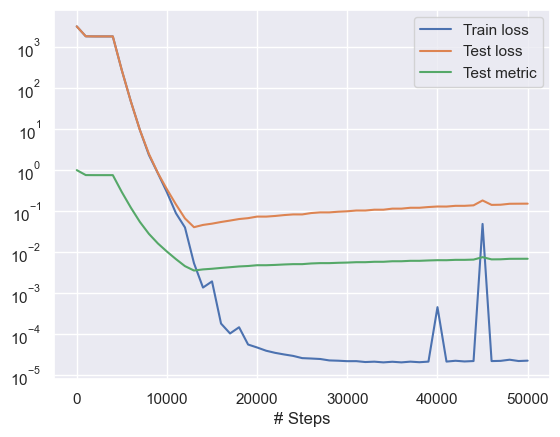

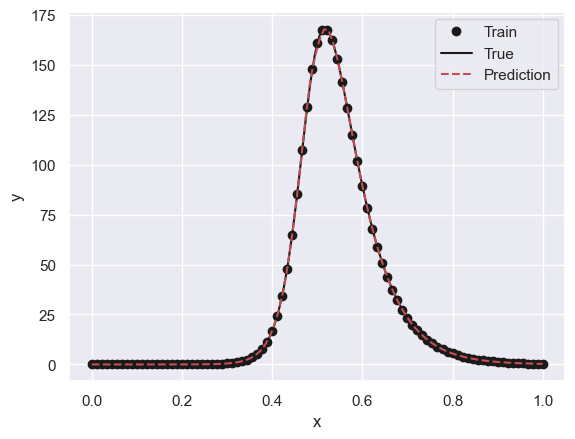

In [39]:
# disable latex for deepxde plots
plt.rc('text', usetex=False)

dde.saveplot(
  loss_history,
  train_state,
  issave=True,
  isplot=True,
  output_dir="data/split"
)

plt.rc('text', usetex=True)

Extract the weights from the trained model to use in the second network.

In [40]:
weights = model.state_dict()

### Second network definition

Define the time domain geometry, scaled to the range [0, 1].

In [41]:
geom = dde.geometry.TimeDomain(scale_time(T0), scale_time(TF))

Define the beta parameter as a trainable variable with initial guess.

In [42]:
beta_var = dde.Variable(0.5)

Define the ODE system, adjusted to use the scaled data.

In [43]:
C1 = (TF - T0) * C / N
C2 = (TF - T0) * delta


def ode_system(t, y):
  S = y[:, 0:1]
  I = y[:, 1:2]
  _R = y[:, 2:3]
  dS_t = dde.grad.jacobian(y, t, i=0)
  dI_t = dde.grad.jacobian(y, t, i=1)
  dR_t = dde.grad.jacobian(y, t, i=2)

  res_s = dS_t - (- C1 * beta_var * I * S)
  res_i = dI_t - (C1 * beta_var * I * S - C2 * I)
  res_r = dR_t - (C2 * I)
  return torch.cat([res_s, res_i, res_r], dim=1)

Define the initial condition.

In [44]:
def boundary(_, on_initial):
  return on_initial


ic_S = dde.icbc.IC(geom, lambda t: scale_population(S0), boundary, component=0)
ic_I = dde.icbc.IC(geom, lambda t: scale_population(I0), boundary, component=1)
ic_R = dde.icbc.IC(geom, lambda t: scale_population(R0), boundary, component=2)

Define the ODE problem with the ICs.

We use 90 points inside the domain and 2 points on the boundary (the start and the end of the time domain).

We use the synthetic (and scaled) time domain to define the points where the data is observed.

In [45]:
data = dde.data.PDE(
  geom,
  ode_system,
  [ic_S, ic_I, ic_R],
  num_domain=90,
  num_boundary=2,
  anchors=t_train,
  solution=true_solution,
  num_test=10
)

Define the network.

Transfer the weights from the first network to the second network.

In [46]:
class ThreeNets(torch.nn.Module):
  def __init__(self, layer_size, activation, initializer, weights_I):
    super().__init__()
    self.net_S = dde.nn.pytorch.FNN(layer_size, activation, initializer)
    self.net_I = dde.nn.pytorch.FNN(layer_size, activation, initializer)
    self.net_R = dde.nn.pytorch.FNN(layer_size, activation, initializer)

    self.net_I.load_state_dict(weights_I)
    self.regularizer = None

  def forward(self, x):
    S_pred = self.net_S(x)
    I_pred = self.net_I(x)
    R_pred = self.net_R(x)
    return torch.cat([S_pred, I_pred, R_pred], dim=1)


net = ThreeNets(layer_size, activation, initializer, weights)

Define the model, including the beta parameter as an external trainable variable.

In [47]:
model = dde.Model(data, net)

Compile the model.

In [48]:
model.compile(
  optimizer=optimizer,
  lr=lr,
  loss_weights=[1] * 4,
  external_trainable_variables=[beta_var],
  metrics=["l2 relative error"]
)

Compiling model...
'compile' took 0.000491 s



Train the model.

In [49]:
loss_history, train_state = model.train(iterations=iterations)

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [7.73e+05, 3.14e+05, 8.80e-06, 0.00e+00]    [8.67e+05, 3.14e+05, 8.80e-06, 0.00e+00]    [9.96e-01]    
1000      [2.31e+02, 2.55e+05, 5.98e-03, 1.26e+02]    [1.61e+02, 2.55e+05, 5.98e-03, 1.26e+02]    [9.18e-01]    
2000      [6.76e+01, 2.09e+05, 2.68e-03, 1.53e+01]    [3.95e+01, 2.09e+05, 2.68e-03, 1.53e+01]    [8.61e-01]    
3000      [6.48e+00, 1.69e+05, 3.45e-03, 1.18e-01]    [1.95e+00, 1.69e+05, 3.45e-03, 1.18e-01]    [8.10e-01]    
4000      [3.17e+00, 1.33e+05, 8.49e-04, 6.05e-01]    [5.62e-01, 1.33e+05, 8.49e-04, 6.05e-01]    [7.64e-01]    
5000      [2.16e+00, 1.02e+05, 1.58e-04, 3.04e-01]    [4.32e-01, 1.02e+05, 1.58e-04, 3.04e-01]    [7.27e-01]    
6000      [1.24e+00, 7.59e+04, 4.82e-05, 5.90e-02]    [3.87e-01, 7.59e+04, 4.82e-05, 5.90e-02]    [6.98e-01]    
7000      [8.02e-01, 5.40e+04, 5.54e-05, 4.97e-03]    [3.39e-01, 5.40e+04, 5.

## Evaluation

Visualize and save the loss history.

Saving loss history to data/loss.dat ...
Saving training data to data/train.dat ...
Saving test data to data/test.dat ...


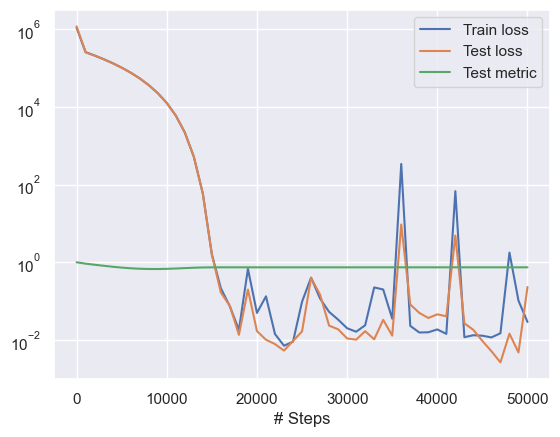

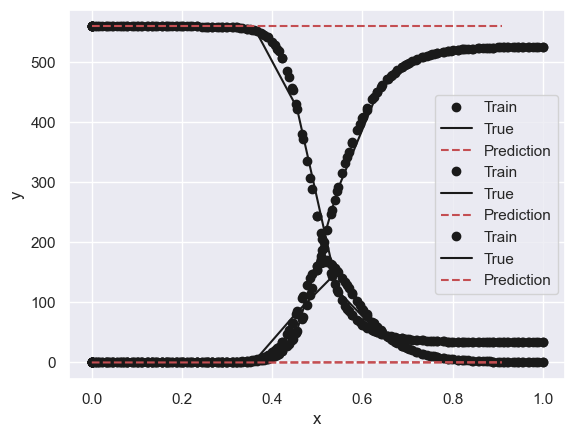

In [50]:
# disable latex for deepxde plots
plt.rc('text', usetex=False)

dde.saveplot(
  loss_history,
  train_state,
  issave=True,
  isplot=True,
  output_dir="data"
)

plt.rc('text', usetex=True)

Generate predictions using the trained model and true values from the `true_solution` function.

In [51]:
t_test = np.linspace(scale_time(T0), scale_time(TF), 100)

y_pred = model.predict(t_test.reshape(-1, 1))
S_pred, I_pred, R_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

S_true, I_true, R_true = true_solution(t_test.reshape(-1, 1)).T

Unscale the data for visualization.

In [52]:
t_test = unscale_time(t_test)
S_true = unscale_population(S_true)
I_true = unscale_population(I_true)
R_true = unscale_population(R_true)

S_pred = unscale_population(S_pred)
I_pred = unscale_population(I_pred)
R_pred = unscale_population(R_pred)

Plot the true solution and the predicted solution.

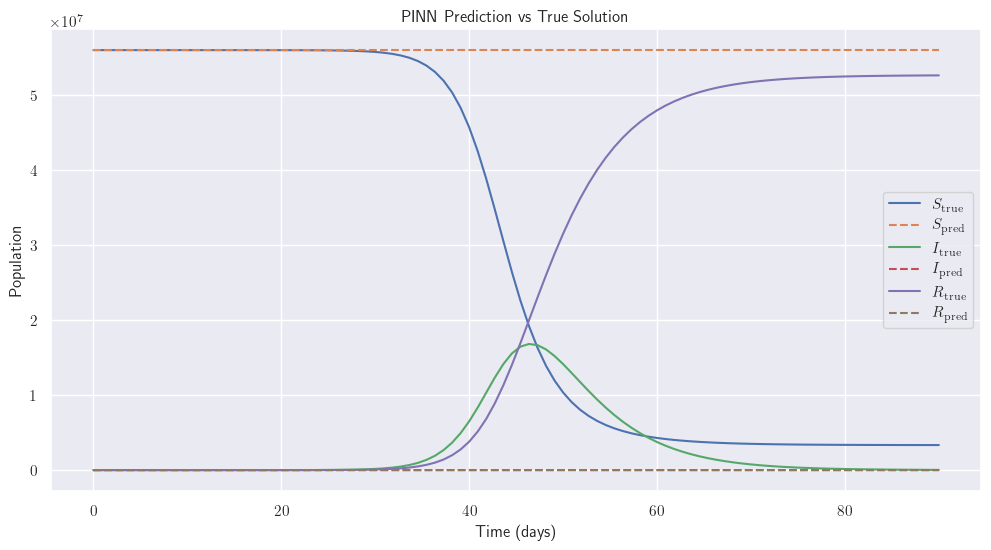

In [53]:
plt.subplots(figsize=(12, 6))

sns.lineplot(x=t_test, y=S_true, label="$S_{\mathrm{true}}$")
sns.lineplot(x=t_test, y=S_pred, label="$S_{\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t_test, y=I_true, label="$I_{\mathrm{true}}$")
sns.lineplot(x=t_test, y=I_pred, label="$I_{\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t_test, y=R_true, label="$R_{\mathrm{true}}$")
sns.lineplot(x=t_test, y=R_pred, label="$R_{\mathrm{pred}}$", linestyle="--")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("PINN Prediction vs True Solution")
plt.legend()
plt.savefig("data/split/predictions.png")
plt.show()